<a href="https://colab.research.google.com/github/dlohmus/rattaringlus/blob/main/Tartu_rattaringlus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tartu rattaringluse rataste kasutatavuse analüüs

##Rühmatöö aines andmeteaduse võimalused äriettevõttes

###Raivo Kasepuu
###Diana Lõhmus
###Irina Rips
###Lauri Ütsik

## Sissejuhatus

Tartu Rattaringlus on avalik iseteenindusega rataste kasutamise süsteem lühikesteks sõitudeks Tartu linnas. Meie analüüsi põhiliseks eesmärgiks on saada ülevaade rataste kasutusest, et optimeerida laenutuspunktide asukohti.
Kõrvaleesmärkidena aitab meie analüüs planeerida jalgrataste korralisi hooldusi. Selleks leiame iga jalgratta keskmise kilometraaži ühes kalendrikuus. Jalgrataste hooldusintervall on 500 km. Teise kõrvaleesmärgina selgitame analüüsiga välja 5 kõige problemaatilisemat jalgrataste laenutuskohta, et hooldusmeeskonnal oleks võimalik vahetada nendes laenutuspunktides kontrollerid.

## Andmeallikad

Analüüsis kasutatakse Tartu Rattaringluse avaandmeid aadressilt https://avaandmed.eesti.ee/datasets/tartu-linnavalitsuse-andmekogud-rattaringlus. Andmed on täielikud. Kokku on andmeid ligikaudu 170 000 rida, puuduvaid väärtusi ei esine. 

## Andmete kirjeldus koos andmetüübiga

1.   Laenutamise kuupäev  /kuupäev/
2.   Laenutamise kellaaeg /kellaaeg/
3.   Tagastamise kuupäev  /kuupäev/
4.   Tagastamise kellaaeg  /kellaaeg/
5.   Liikmelisus (mille alusel laenutati) /tekst/
6.   Sõidu kilometraaz (km) /ujukomaarv/
7.   Laenutuse kestvus (min) /ujukomaarv/
8.   Ratta ID /täisarv/
9.   Jalgratta tüüp (tavaratas või elektriratas) /tekst/
10.  Laenutuse hind /ujukomaarv/
11.  Laenutuspunkt  /tekst/
12.  Tagastuspunkt  /tekst/



In [243]:
import pandas as pd
import numpy as np

In [244]:
url= 'https://github.com/dlohmus/rattaringlus/raw/main/Smart_Bike_Tartu_july_2019.xlsx'

In [245]:
rattaringlus_df = pd.read_excel(url, sheet_name ='Tartu Smart Bike July 2019')

In [246]:
print(rattaringlus_df.columns.ravel())
display(rattaringlus_df.head(3))
rattaringlus_df.info()

['Unlock Date' 'Unlock Time' 'Lock Date' 'Lock Time' 'Membership' 'Length'
 'Duration (Minutes)' 'Bike No' 'Bike Type' 'Cost' 'Start Station'
 'End Station']


,Unlock Date,Unlock Time,Lock Date,Lock Time,Membership,Length,Duration (Minutes),Bike No,Bike Type,Cost,Start Station,End Station
0,2019-07-01 00:00:00,08:05:03,2019-07-01 00:00:00,08:05:03,Technician,0,0.0,2207.0,Pedelec,0.0,Raudteejaam,Raudteejaam
1,2019-07-01 00:00:00,08:12:05,2019-07-01 00:00:00,08:12:05,Technician,0,0.0,2298.0,Pedelec,0.0,Raudteejaam,Raudteejaam
2,2019-07-01 00:00:00,09:33:21,2019-07-01 00:00:00,09:33:21,Technician,0,0.0,2654.0,Pedelec,0.0,Töökoda,Töökoda


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170023 entries, 0 to 170022
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unlock Date         170010 non-null  object 
 1   Unlock Time         170010 non-null  object 
 2   Lock Date           170010 non-null  object 
 3   Lock Time           170010 non-null  object 
 4   Membership          170003 non-null  object 
 5   Length              170003 non-null  object 
 6   Duration (Minutes)  169996 non-null  float64
 7   Bike No             169996 non-null  float64
 8   Bike Type           169996 non-null  object 
 9   Cost                169996 non-null  float64
 10  Start Station       169996 non-null  object 
 11  End Station         169996 non-null  object 
dtypes: float64(3), object(9)
memory usage: 15.6+ MB


###Andmete ettevalmistamine

Enne analüüsi tegemist puhastame andmed. Selleks eemaldame kõigepealt andmetest tühjad read ning ning need read, kus laenutuse kuupäev ei jäänud vaadeldava juuli 2019 perioodi (7 rida) ning read, kus rattanumber puudub (7 rida). Kuna ratast tnumbriga 0 tegelikult ei eksisteeri, eemaldame need read. Lisaks eemaldame andmete hulgast tehnikute jalgrataste kasutuse (10 060 rida), sest nad transportisid jalgrattaid veokil laenutuspunktist töökotta või vastupidi. Veel on andmete hulgas ridu, kus laenutuspunkti nimi on "Töökoda" (228 rida) või "Warehouse" (20 rida), need read võib samuti eemaldada. Sellenimelisi laenutuspunkte tegelikult ei eksisteeri ning tegemist on testkasutusega.

Samuti on andmetes veerge, mida me oma analüüsis ei kasuta. Veerus laenutuse hind on kõik väärtused nullid, sest tegemist oli prooviperioodiga. Andmetes on juba olemas veerg sõidu kestvus (minutites), seetõttu ei ole meil vaja oma analüüsis kasutada veerge laenutamise kellaaeg ning tagastamise kellaaeg.

In [247]:
#Tühjade ridade eemaldamine
puudu = pd.isnull(rattaringlus_df['Unlock Date']) 
olemas = pd.notnull(rattaringlus_df['Unlock Date'])

rattaringlus_df = rattaringlus_df.loc[olemas]

In [248]:
#Eemaldame read, kus puudub rattanumber
rattaringlus_df.dropna(subset = ['Bike No'], inplace=True)

In [249]:
#Vigaste andmete eemaldamine ja andmetüüpide teisendamine
#Vaatame laenutamise kuupäeva veeru väärtuseid
erindid = rattaringlus_df['Unlock Date'].unique()
print(erindid)

#Otsime andmetes hulgast read, kus laenutamise kuupäev ei ole kuupäeva kujul või ei jää vahemikku 01.07.2019 - 31.07.2019 ja eemaldame need
display(rattaringlus_df.loc[rattaringlus_df['Unlock Date']== 'Mobile App'])
rattaringlus_df.drop(rattaringlus_df[rattaringlus_df['Unlock Date']== 'Mobile App'].index, inplace = True)

#Teisendame laenutamise kuupäeva õigesse formaati
rattaringlus_df['Unlock Date'] = rattaringlus_df['Unlock Date'].astype('datetime64[ns]')

display(rattaringlus_df.loc[rattaringlus_df['Unlock Date'] < '2019-07-01'])
rattaringlus_df.drop(rattaringlus_df[rattaringlus_df['Unlock Date'] < '2019-07-01'].index, inplace = True)



[datetime.datetime(2019, 7, 1, 0, 0) datetime.datetime(2019, 7, 2, 0, 0)
 datetime.datetime(2019, 7, 3, 0, 0) datetime.datetime(2019, 7, 4, 0, 0)
 datetime.datetime(2019, 7, 5, 0, 0) datetime.datetime(2019, 7, 6, 0, 0)
 datetime.datetime(2019, 7, 7, 0, 0) datetime.datetime(2019, 7, 8, 0, 0)
 datetime.datetime(2019, 7, 9, 0, 0) datetime.datetime(2019, 7, 10, 0, 0)
 datetime.datetime(2019, 7, 11, 0, 0) datetime.datetime(2019, 7, 12, 0, 0)
 datetime.datetime(2019, 7, 13, 0, 0) datetime.datetime(2019, 7, 14, 0, 0)
 datetime.datetime(2019, 7, 15, 0, 0) datetime.datetime(2019, 7, 16, 0, 0)
 datetime.datetime(2019, 7, 17, 0, 0) datetime.datetime(2019, 7, 18, 0, 0)
 datetime.datetime(2019, 7, 19, 0, 0) datetime.datetime(2019, 7, 20, 0, 0)
 datetime.datetime(2019, 7, 21, 0, 0) datetime.datetime(2019, 7, 22, 0, 0)
 datetime.datetime(2019, 7, 23, 0, 0) datetime.datetime(2019, 7, 24, 0, 0)
 datetime.datetime(2019, 7, 25, 0, 0) datetime.datetime(2019, 7, 26, 0, 0)
 datetime.datetime(2019, 7, 27, 0,

,Unlock Date,Unlock Time,Lock Date,Lock Time,Membership,Length,Duration (Minutes),Bike No,Bike Type,Cost,Start Station,End Station


,Unlock Date,Unlock Time,Lock Date,Lock Time,Membership,Length,Duration (Minutes),Bike No,Bike Type,Cost,Start Station,End Station


In [250]:
#Otsime andmete hulglgast tehnikute rattakasutust sisaldavad read ning eemaldame need
display(rattaringlus_df.loc[rattaringlus_df['Membership']== 'Technician'])
rattaringlus_df.drop(rattaringlus_df[rattaringlus_df['Membership']== 'Technician'].index, inplace = True)

,Unlock Date,Unlock Time,Lock Date,Lock Time,Membership,Length,Duration (Minutes),Bike No,Bike Type,Cost,Start Station,End Station
0,2019-07-01,08:05:03,2019-07-01 00:00:00,08:05:03,Technician,0,0.00,2207.0,Pedelec,0.0,Raudteejaam,Raudteejaam
1,2019-07-01,08:12:05,2019-07-01 00:00:00,08:12:05,Technician,0,0.00,2298.0,Pedelec,0.0,Raudteejaam,Raudteejaam
2,2019-07-01,09:33:21,2019-07-01 00:00:00,09:33:21,Technician,0,0.00,2654.0,Pedelec,0.0,Töökoda,Töökoda
3,2019-07-01,09:33:25,2019-07-01 00:00:00,09:33:25,Technician,0,0.00,2654.0,Pedelec,0.0,Töökoda,Töökoda
4,2019-07-01,09:37:00,2019-07-01 00:00:00,09:37:00,Technician,0,0.00,2654.0,Pedelec,0.0,Töökoda,Töökoda
...,...,...,...,...,...,...,...,...,...,...,...,...
169609,2019-07-31,21:47:58,2019-07-31 00:00:00,21:48:11,Technician,0,0.20,2714.0,Bike,0.0,Anne saun,Anne saun
169612,2019-07-31,21:48:16,2019-07-31 00:00:00,21:48:30,Technician,0.01,0.23,2403.0,Pedelec,0.0,Anne saun,Anne saun
169615,2019-07-31,21:48:54,2019-07-31 00:00:00,21:49:16,Technician,0.01,0.37,2535.0,Pedelec,0.0,Anne saun,Anne saun
169617,2019-07-31,21:49:17,2019-07-31 00:00:00,21:49:38,Technician,0.01,0.36,2511.0,Pedelec,0.0,Tähtvere spordipark,Tähtvere spordipark


In [251]:
#Otsime andmete hulgast testkasutuse read ning eemaldame need
display(rattaringlus_df.loc[rattaringlus_df['Start Station']== 'Töökoda'])
display(rattaringlus_df.loc[rattaringlus_df['Start Station']== 'Warehouse'])
testkasutus = rattaringlus_df[rattaringlus_df['Start Station'].isin(['Töökoda', 'Warehouse'])].index
rattaringlus_df.drop(testkasutus, inplace = True)

,Unlock Date,Unlock Time,Lock Date,Lock Time,Membership,Length,Duration (Minutes),Bike No,Bike Type,Cost,Start Station,End Station
2237,2019-07-01,13:48:30,2019-07-01 00:00:00,13:53:28,3 month free membership,0.87,4.97,2753.0,Bike,0.0,Töökoda,Töökoda
2542,2019-07-01,14:37:14,2019-07-01 00:00:00,14:52:00,3 month free membership,2.64,14.76,2753.0,Bike,0.0,Töökoda,Töökoda
2714,2019-07-01,14:55:49,2019-07-01 00:00:00,15:44:35,1 month free membership,6.43,48.76,2753.0,Bike,0.0,Töökoda,Töökoda
3101,2019-07-01,15:45:51,2019-07-01 00:00:00,15:56:45,1 month free membership,2.36,10.90,2753.0,Bike,0.0,Töökoda,Töökoda
3598,2019-07-01,16:59:05,2019-07-01 00:00:00,17:09:49,1 month free membership,2.02,10.73,2753.0,Bike,0.0,Töökoda,Töökoda
...,...,...,...,...,...,...,...,...,...,...,...,...
167248,2019-07-31,15:25:42,2019-07-31 00:00:00,15:28:24,1 Year Membership,0.41,2.69,2753.0,Bike,0.0,Töökoda,Töökoda
167364,2019-07-31,15:43:57,2019-07-31 00:00:00,15:44:08,3-Month Free Membership,0,0.19,2753.0,Bike,0.0,Töökoda,Töökoda
167563,2019-07-31,16:17:07,2019-07-31 00:00:00,16:18:14,Free Membership (with bus card),0.04,1.11,2753.0,Bike,0.0,Töökoda,Töökoda
168656,2019-07-31,18:56:37,2019-07-31 00:00:00,19:02:48,3 month free membership,0.76,6.19,2753.0,Bike,0.0,Töökoda,Töökoda


,Unlock Date,Unlock Time,Lock Date,Lock Time,Membership,Length,Duration (Minutes),Bike No,Bike Type,Cost,Start Station,End Station
1506,2019-07-01,11:14:03,2019-07-02 00:00:00,16:02:48,1 month free membership,0,1728.74,2102.0,Pedelec,4.0,Warehouse,Warehouse
9971,2019-07-02,20:01:41,2019-07-02 00:00:00,20:38:00,3-Month Free Membership,0,36.30,2667.0,Bike,0.0,Warehouse,Warehouse
10187,2019-07-02,20:46:33,2019-07-04 00:00:00,10:56:41,3 month free membership,0,2290.14,2219.0,Pedelec,4.0,Warehouse,Warehouse
60401,2019-07-12,18:51:02,2019-07-12 00:00:00,19:14:00,Free Membership (with bus card),5.04,22.96,2511.0,Pedelec,0.0,Warehouse,Warehouse
60676,2019-07-12,19:25:05,2019-07-12 00:00:00,19:27:34,Free Membership (with bus card),0.32,2.49,2511.0,Pedelec,0.0,Warehouse,Warehouse
60722,2019-07-12,19:30:10,2019-07-12 00:00:00,20:13:39,1 YEAR MEMBERSHIP,1.19,43.48,2511.0,Pedelec,0.0,Warehouse,Warehouse
61000,2019-07-12,20:14:02,2019-07-12 00:00:00,20:49:36,1 YEAR MEMBERSHIP,6.69,35.58,2511.0,Pedelec,0.0,Warehouse,Warehouse
61268,2019-07-12,20:50:35,2019-07-12 00:00:00,20:56:50,1 YEAR MEMBERSHIP,1.18,6.25,2511.0,Pedelec,0.0,Warehouse,Warehouse
61350,2019-07-12,21:02:47,2019-07-12 00:00:00,21:45:50,1 YEAR MEMBERSHIP,7.68,43.04,2511.0,Pedelec,0.0,Warehouse,Warehouse
87116,2019-07-17,17:27:44,2019-07-17 00:00:00,17:52:11,3 month free membership,6.15,24.45,2511.0,Pedelec,0.0,Warehouse,Warehouse


In [252]:
#Eemaldame andmetabelist laenutuse hinna, laenutamise ja tagastamise kellaaegade veerud.
rattaringlus_df.drop(["Cost","Unlock Time","Lock Time"], axis=1, inplace=True)

In [253]:
#Muudame andmetabeli veergude andmetüübid õigesse formaati
rattaringlus_df['Lock Date'] = rattaringlus_df['Lock Date'].astype('datetime64[ns]')
rattaringlus_df['Membership'] = rattaringlus_df['Membership'].astype('string')
rattaringlus_df['Length'] = rattaringlus_df['Length'].astype('float64')
rattaringlus_df['Bike No'] = rattaringlus_df['Bike No'].astype('int')
rattaringlus_df['Bike Type'] = rattaringlus_df['Bike Type'].astype('string')
rattaringlus_df['Start Station'] = rattaringlus_df['Start Station'].astype('string')
rattaringlus_df['End Station'] = rattaringlus_df['End Station'].astype('string')

In [254]:
#Vaatame uuesti andmeid ja andmetabeli veergude formaati
print(rattaringlus_df.columns.ravel())
display(rattaringlus_df.head(3))
rattaringlus_df.info()

['Unlock Date' 'Lock Date' 'Membership' 'Length' 'Duration (Minutes)'
 'Bike No' 'Bike Type' 'Start Station' 'End Station']


,Unlock Date,Lock Date,Membership,Length,Duration (Minutes),Bike No,Bike Type,Start Station,End Station
87,2019-07-01,2019-07-01,Free Membership (with bus card),3.96,22.10,2182,Pedelec,Tarmeko,Annelinna kiir
97,2019-07-01,2019-07-01,3-Month Free Membership,3.75,21.93,2219,Pedelec,Orava,Sõbra
160,2019-07-01,2019-07-01,1 month free membership,5.24,54.00,2196,Pedelec,Eeden,Põhja puiestee


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159688 entries, 87 to 170022
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Unlock Date         159688 non-null  datetime64[ns]
 1   Lock Date           159688 non-null  datetime64[ns]
 2   Membership          159688 non-null  string        
 3   Length              159688 non-null  float64       
 4   Duration (Minutes)  159688 non-null  float64       
 5   Bike No             159688 non-null  int64         
 6   Bike Type           159688 non-null  string        
 7   Start Station       159688 non-null  string        
 8   End Station         159688 non-null  string        
dtypes: datetime64[ns](2), float64(2), int64(1), string(4)
memory usage: 12.2 MB


## Ülevaade rataste kasutamisest 2019 aasta juuli kuu jooksul
Laenutuspunktide asukohtade optimeerimiseks leiame 5 kõige vähem kasutatud laenutuspunkti, et need ümber kolida. Samuti leiame 5 kõige populaarsemat laenutuspunkti, et neid oleks võimalik laiendada ning seeläbi jalgrataste kättesaadavust parandada. 

Uueturu             8239
Soola               5700
Eeden               4294
Pirogovi plats      3817
Vabadussild         3533
EMÜ spordihoone      608
Kvissentali          553
Metallica parkla     144
SPARK Demo             3
Delta                  2
Name: Start Station, dtype: Int64
<class 'pandas.core.series.Series'>


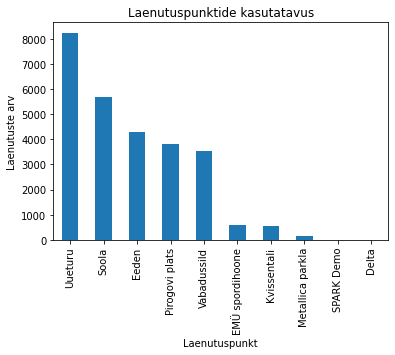

In [273]:
#5 kõige populaarsemat ja 5 vähem kasutatud laenutuspunkti sõidu alustamise järgi
laenutus_df=(rattaringlus_df["Start Station"].value_counts())
pop_df = laenutus_df.iloc[1:6]
last_df = laenutus_df.iloc[-5:]
#paneme need kokku 1 tabeliks
laenutuspunktid = pd.concat([pop_df, last_df])
print(laenutuspunktid)
print(type(laenutuspunktid))

import matplotlib.pyplot as plt
graafikuks = pd.Series(laenutuspunktid)
#print(graafikuks)

graafikuks.plot.bar(xlabel="Laenutuspunkt", ylabel="Laenutuste arv", title="Laenutuspunktide kasutatavus")
plt.show()